In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Dropout, Dense, Flatten
from tensorflow.keras.layers import MaxPooling1D, LSTM,  GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from scipy.fft import fft
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random

In [5]:
import os

# list everything in current working directory
print(os.listdir('/content'))

['.config', 'BCICIV_2a_all_patients.csv', 'sample_data']


In [6]:
import pandas as pd

df = pd.read_csv("/content/BCICIV_2a_all_patients.csv")
print(df.shape)
print(df.head())

(492048, 26)
   patient   time   label  epoch    EEG-Fz     EEG-0     EEG-1     EEG-2  \
0        1 -0.100  tongue      8 -1.681412  2.245496 -0.158350  1.163765   
1        1 -0.096  tongue      8  0.420417  0.587559  1.650510  0.970672   
2        1 -0.092  tongue      8  0.551365  1.499758  0.121302  2.859433   
3        1 -0.088  tongue      8  3.054916 -1.807238  1.843603  2.286812   
4        1 -0.084  tongue      8  2.506710 -2.453101  0.221178  0.127278   

      EEG-3     EEG-4  ...     EEG-8     EEG-9    EEG-10    EEG-11    EEG-12  \
0 -1.523659 -0.575267  ...  0.758116  3.441785  0.305517  1.137473 -1.275763   
1  1.505904  0.891796  ...  1.541586 -0.071620  0.258909 -1.448198  0.142472   
2  2.613414  4.636026  ...  2.649097 -2.137938 -1.612096 -1.610218 -0.410173   
3  5.995872  6.651295  ...  6.031554 -5.249621 -2.672998 -3.452370  0.189081   
4  4.519931  6.249573  ...  7.827097 -5.309546 -2.488783 -3.707608  1.447515   

     EEG-13    EEG-14    EEG-Pz    EEG-15    EEG-

In [7]:
import pandas as pd
import glob

# find all csvs that match the pattern
csv_files = glob.glob("/content/BCICIV_2a_*.csv")

# read them and concatenate into one DataFrame
df_list = [pd.read_csv(f) for f in csv_files]
df = pd.concat(df_list, ignore_index=True)

print("Combined shape:", df.shape)
print(df.head())

Combined shape: (492048, 26)
   patient   time   label  epoch    EEG-Fz     EEG-0     EEG-1     EEG-2  \
0        1 -0.100  tongue      8 -1.681412  2.245496 -0.158350  1.163765   
1        1 -0.096  tongue      8  0.420417  0.587559  1.650510  0.970672   
2        1 -0.092  tongue      8  0.551365  1.499758  0.121302  2.859433   
3        1 -0.088  tongue      8  3.054916 -1.807238  1.843603  2.286812   
4        1 -0.084  tongue      8  2.506710 -2.453101  0.221178  0.127278   

      EEG-3     EEG-4  ...     EEG-8     EEG-9    EEG-10    EEG-11    EEG-12  \
0 -1.523659 -0.575267  ...  0.758116  3.441785  0.305517  1.137473 -1.275763   
1  1.505904  0.891796  ...  1.541586 -0.071620  0.258909 -1.448198  0.142472   
2  2.613414  4.636026  ...  2.649097 -2.137938 -1.612096 -1.610218 -0.410173   
3  5.995872  6.651295  ...  6.031554 -5.249621 -2.672998 -3.452370  0.189081   
4  4.519931  6.249573  ...  7.827097 -5.309546 -2.488783 -3.707608  1.447515   

     EEG-13    EEG-14    EEG-Pz  

In [8]:
df = df.dropna()
eeg_columns = df.columns[4:]
print("Channels used:", eeg_columns)

Channels used: Index(['EEG-Fz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5',
       'EEG-C3', 'EEG-6', 'EEG-Cz', 'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9',
       'EEG-10', 'EEG-11', 'EEG-12', 'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15',
       'EEG-16'],
      dtype='object')


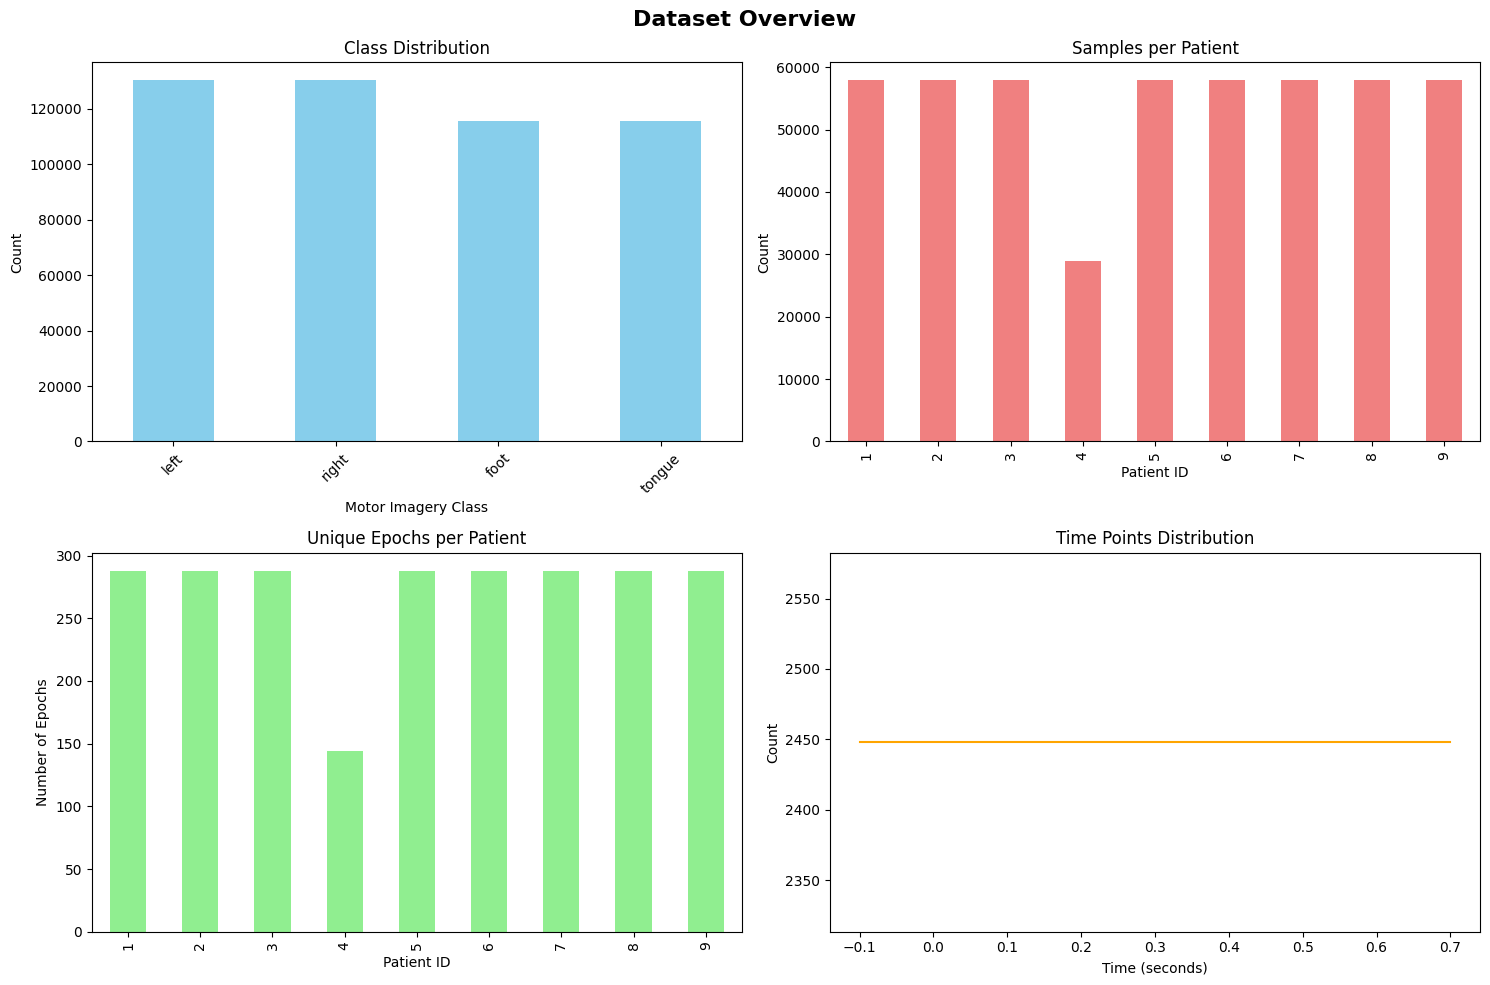

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Dataset Overview', fontsize=16, fontweight='bold')

# Distribution of classes
df['label'].value_counts().plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Class Distribution')
axes[0,0].set_xlabel('Motor Imagery Class')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)

# Distribution of patients
df['patient'].value_counts().sort_index().plot(kind='bar', ax=axes[0,1], color='lightcoral')
axes[0,1].set_title('Samples per Patient')
axes[0,1].set_xlabel('Patient ID')
axes[0,1].set_ylabel('Count')

# Distribution of epochs per patient
epoch_counts = df.groupby('patient')['epoch'].nunique()
epoch_counts.plot(kind='bar', ax=axes[1,0], color='lightgreen')
axes[1,0].set_title('Unique Epochs per Patient')
axes[1,0].set_xlabel('Patient ID')
axes[1,0].set_ylabel('Number of Epochs')

# Time points distribution
time_counts = df['time'].value_counts().sort_index()
time_counts.plot(ax=axes[1,1], color='orange')
axes[1,1].set_title('Time Points Distribution')
axes[1,1].set_xlabel('Time (seconds)')
axes[1,1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [10]:
df['label'].unique()

array(['tongue', 'foot', 'right', 'left'], dtype=object)

In [11]:
df[eeg_columns] = df[eeg_columns].apply(pd.to_numeric, errors='coerce')
df = df.dropna()

# Check class distribution
print("Class distribution before windowing:")
print(df['label'].value_counts())

# Group by epochs
grouped = df.groupby('epoch')
X, y = [], []

target_length = 201

for epoch, group in grouped:
    data = group[eeg_columns].values.T
    if data.shape[1] > target_length:
        data = data[:, :target_length]
    elif data.shape[1] < target_length:
        pad_width = target_length - data.shape[1]
        data = np.pad(data, ((0, 0), (0, pad_width)), mode='constant')
    X.append(data)
    y.append(group['label'].iloc[0])

X = np.array(X)
y = np.array(y)
print(f"X shape after epoch grouping: {X.shape}")
print(f"y shape: {y.shape}")

# Channel-wise normalization
n_samples, n_channels, n_time_points = X.shape
X_normalized = np.zeros_like(X)

for i in range(n_samples):
    for ch in range(n_channels):
        scaler = StandardScaler()
        X_normalized[i, ch, :] = scaler.fit_transform(X[i, ch, :].reshape(-1, 1)).flatten()

# Frequency-domain features
X_freq = np.zeros((n_samples, n_channels, n_time_points // 2 + 1))
for i in range(n_samples):
    for ch in range(n_channels):
        fft_result = fft(X_normalized[i, ch, :])
        X_freq[i, ch, :] = np.abs(fft_result[:n_time_points // 2 + 1])

# Sliding window
window_size = 50
stride = 10
X_windows, y_windows = [], []

for i in range(n_samples):
    data = X_normalized[i]
    freq_data = X_freq[i]
    num_windows = (n_time_points - window_size) // stride + 1

    for w in range(num_windows):
        start = w * stride
        end = start + window_size
        window = data[:, start:end]

        freq_start = (start * (n_time_points // 2 + 1)) // n_time_points
        freq_end = (end * (n_time_points // 2 + 1)) // n_time_points
        freq_window = freq_data[:, freq_start:freq_end]

        if freq_window.shape[1] < window_size:
            freq_window = np.pad(freq_window, ((0, 0), (0, window_size - freq_window.shape[1])), mode='constant')
        elif freq_window.shape[1] > window_size:
            freq_window = freq_window[:, :window_size]

        combined = np.stack([window, freq_window], axis=-1)
        X_windows.append(combined)
        y_windows.append(y[i])

X_windows = np.array(X_windows)
y_windows = np.array(y_windows)
print(f"X_windows shape (before reshape): {X_windows.shape}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_windows)
y_categorical = tf.keras.utils.to_categorical(y_encoded)
print(f"Encoded y shape (categorical): {y_categorical.shape}")

# Reshape: (samples, time_steps, channels, features) -> (samples, time_steps, channels * features)
X_windows = X_windows.transpose(0, 2, 1, 3)
X_windows = X_windows.reshape(X_windows.shape[0], X_windows.shape[1], X_windows.shape[2] * X_windows.shape[3])
print(f"X_windows shape (final): {X_windows.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_windows, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Class distribution before windowing:
label
left      130248
right     130248
foot      115776
tongue    115776
Name: count, dtype: int64
X shape after epoch grouping: (632, 22, 201)
y shape: (632,)
X_windows shape (before reshape): (10112, 22, 50, 2)
Encoded y shape (categorical): (10112, 4)
X_windows shape (final): (10112, 50, 44)
Train: (8089, 50, 44), (8089, 4)
Test: (2023, 50, 44), (2023, 4)


--- Raw EEG Signal Visualization (Sample) ---


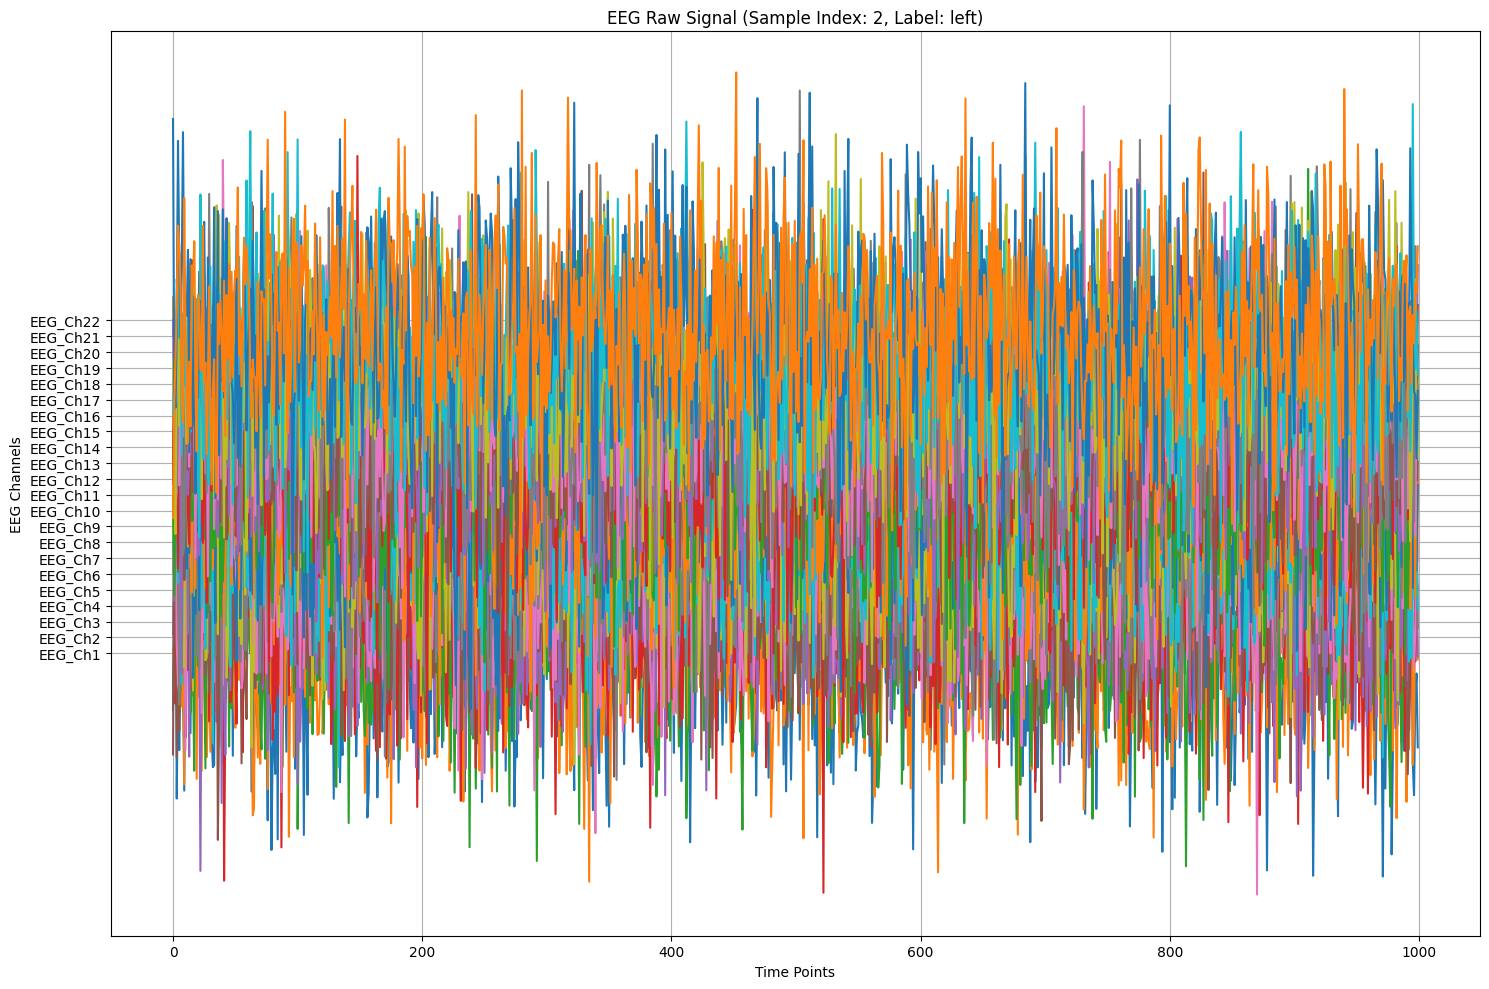


--- Raw vs. Normalized EEG Signal Comparison ---


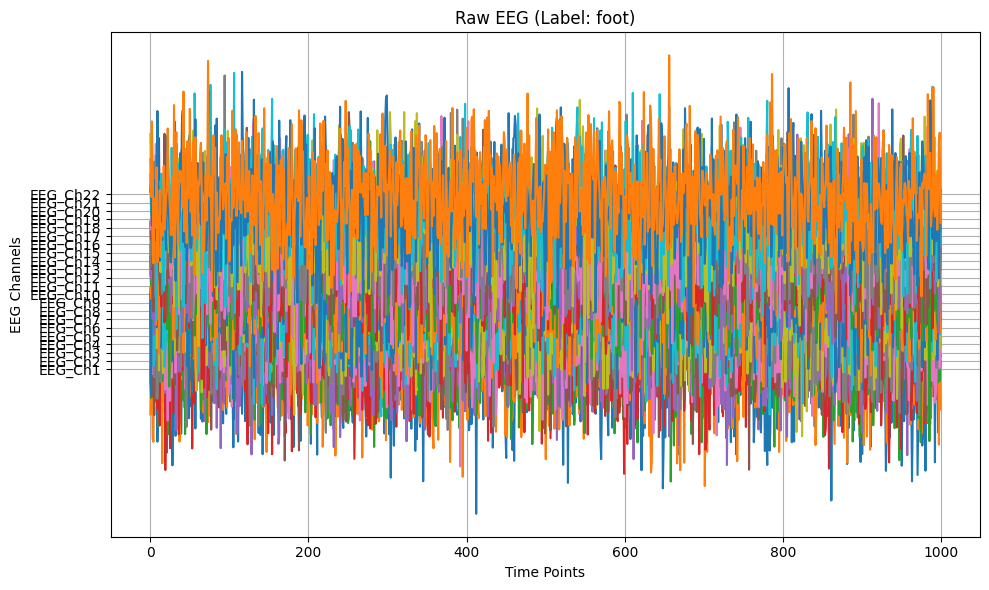

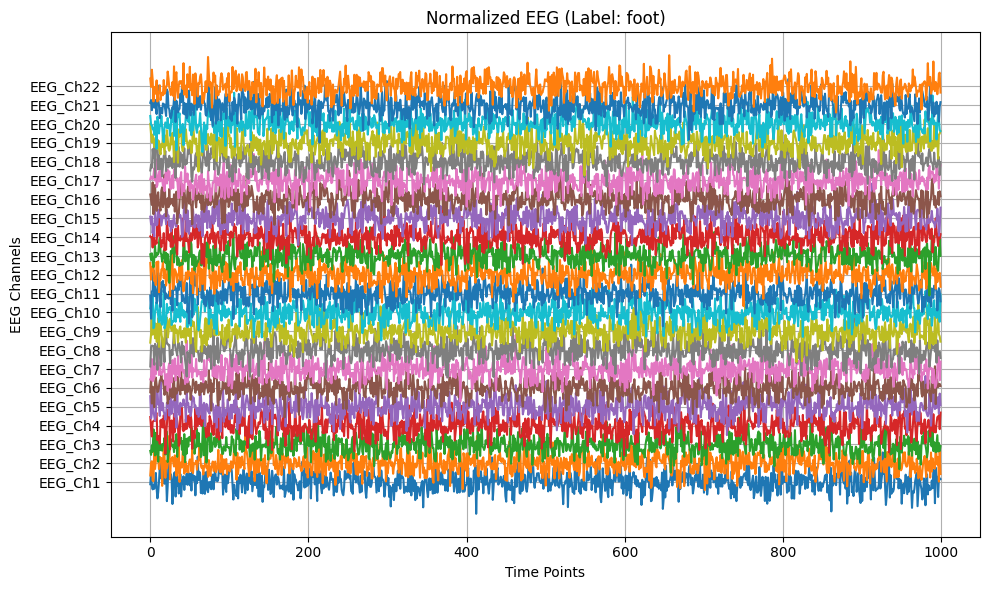


--- EEG Signal Frequency-Domain Visualization (FFT) ---


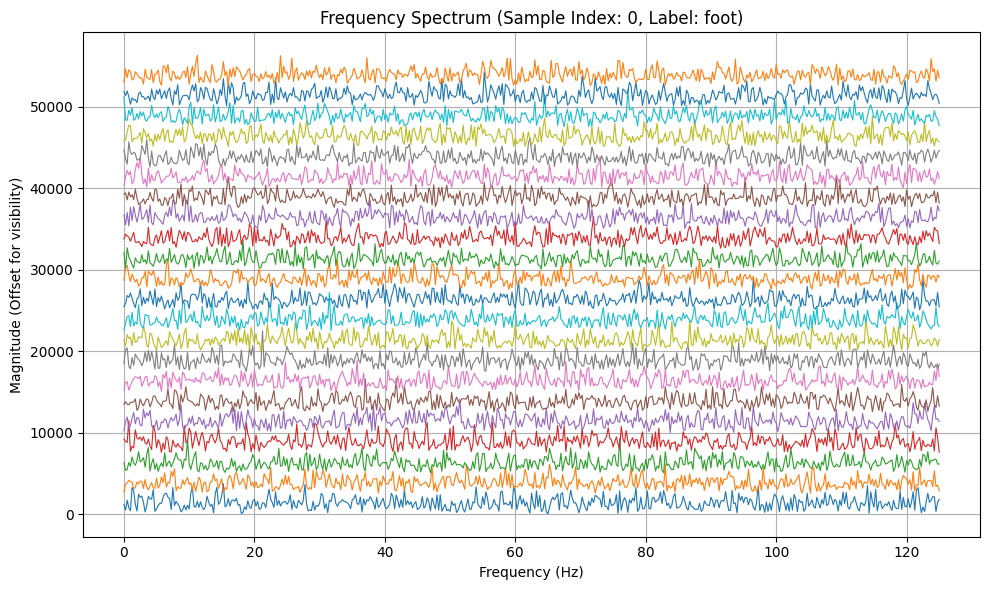


--- Spectrogram-like EEG Heatmap ---


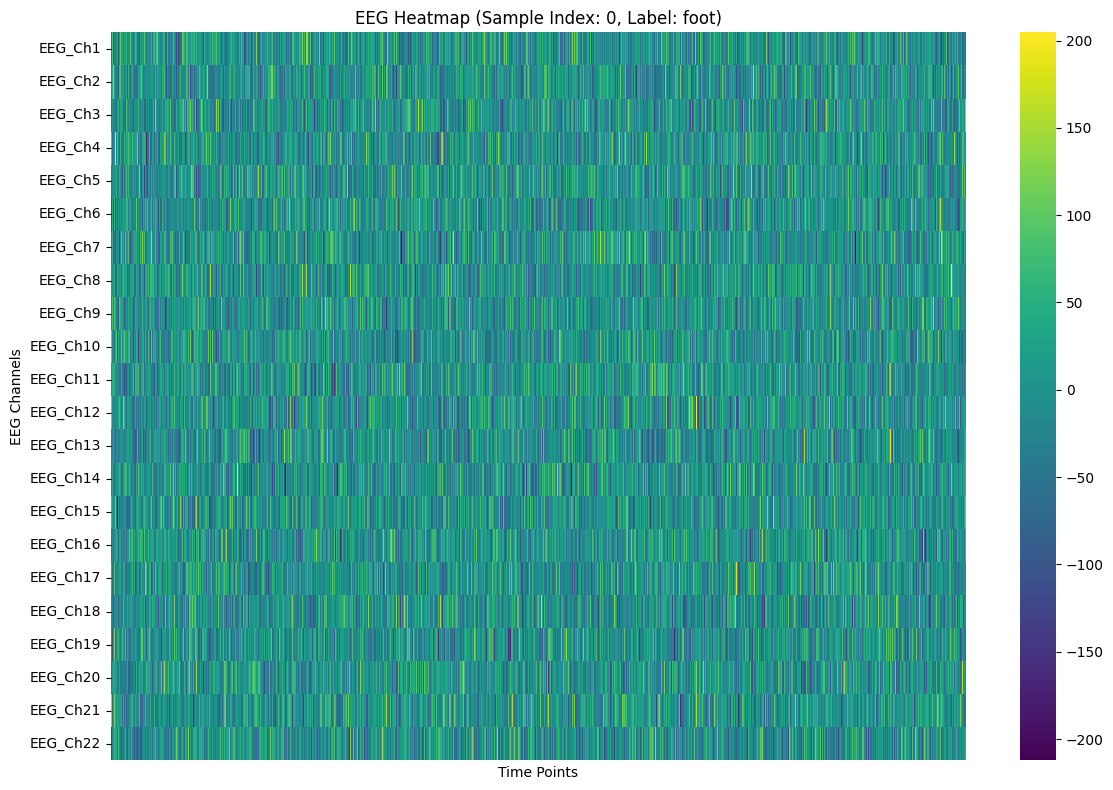


--- EEG Band Power Calculation ---


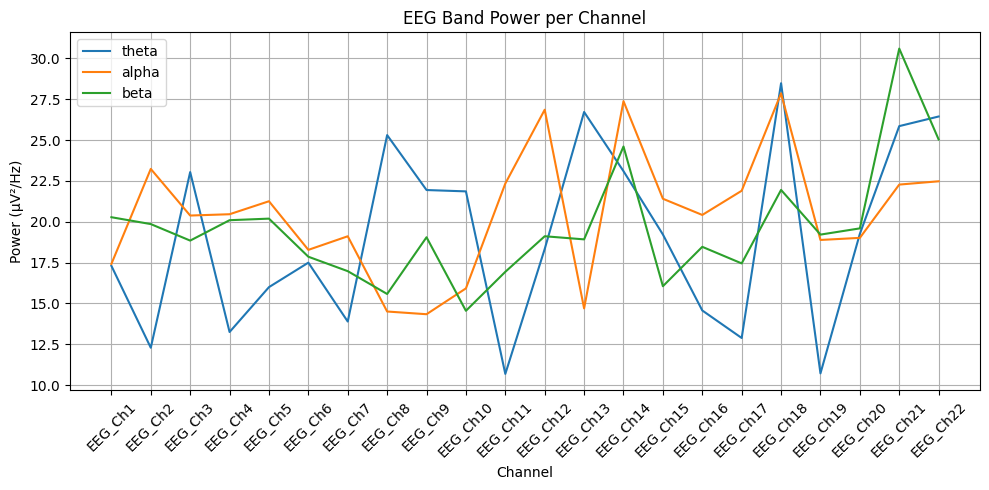


--- PCA and t-SNE Feature Visualization ---


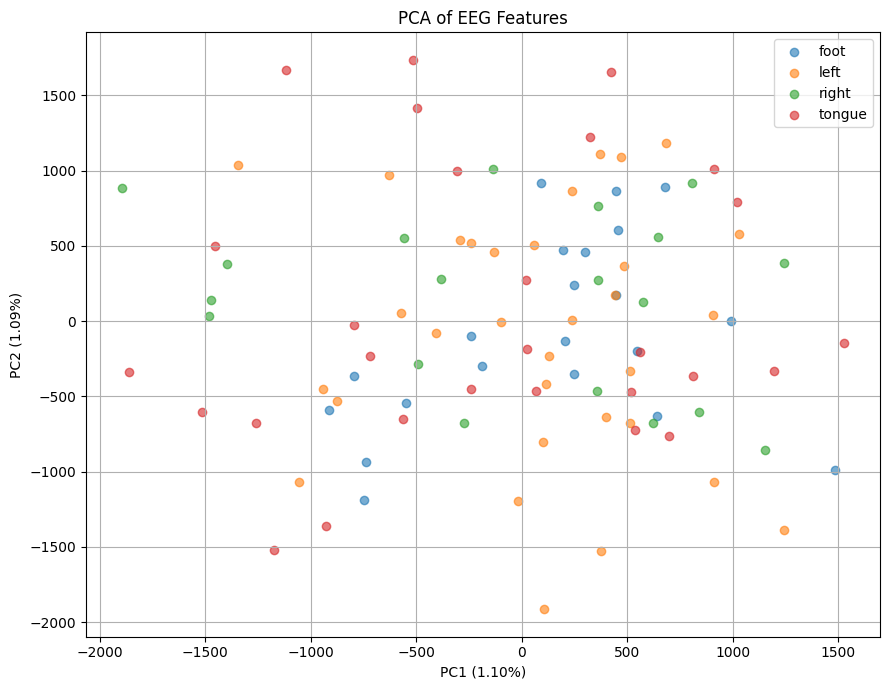

In [12]:
# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from scipy.fft import fft, rfftfreq
from scipy.signal import welch
import random

# --- Parameters for dummy data ---
n_samples = 100
n_channels = 22  # Standard for BCIC IV 2a
n_time_points = 1000  # Assuming 4 seconds at 250 Hz
sf = 250  # Sampling frequency

# Dummy raw EEG data (X)
X = np.random.randn(n_samples, n_channels, n_time_points) * 50

# Dummy labels (y)
labels = ['left', 'right', 'foot', 'tongue']
y = np.array(random.choices(labels, k=n_samples))

# EEG channel names
eeg_columns = [f'EEG_Ch{i+1}' for i in range(n_channels)]

# Normalize EEG data
scaler = StandardScaler()
X_reshaped = X.reshape(-1, n_time_points)
X_normalized_reshaped = scaler.fit_transform(X_reshaped)
X_normalized = X_normalized_reshaped.reshape(n_samples, n_channels, n_time_points)

# Frequency domain (FFT)
X_freq_real = np.abs(np.fft.rfft(X, axis=-1))

# Windowed features for PCA/t-SNE
X_windows = X  # Placeholder

# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = tf.keras.utils.to_categorical(y_encoded)

# --- Visualization: Raw EEG ---
print("--- Raw EEG Signal Visualization (Sample) ---")
left_indices = np.where(y == 'left')[0]
sample_idx = left_indices[0] if len(left_indices) > 0 else random.randint(0, n_samples - 1)
sample_data = X[sample_idx]

plt.figure(figsize=(15, 10))
for ch in range(sample_data.shape[0]):
    plt.plot(sample_data[ch] + ch * 10, label=f'Ch {eeg_columns[ch]}')
plt.yticks([ch * 10 for ch in range(sample_data.shape[0])], eeg_columns)
plt.title(f'EEG Raw Signal (Sample Index: {sample_idx}, Label: {y[sample_idx]})')
plt.xlabel("Time Points")
plt.ylabel("EEG Channels")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Comparison: Raw vs Normalized ---
print("\n--- Raw vs. Normalized EEG Signal Comparison ---")
target_class = 'foot'
class_indices = np.where(y == target_class)[0]
sample_idx = class_indices[0] if len(class_indices) > 0 else random.randint(0, n_samples - 1)
raw_sample = X[sample_idx]
norm_sample = X_normalized[sample_idx]
start_time, end_time = 0, raw_sample.shape[1]
raw_clip = raw_sample[:, start_time:end_time]
norm_clip = norm_sample[:, start_time:end_time]
time_points = np.arange(start_time, end_time)

# Raw EEG
plt.figure(figsize=(10, 6))
for ch in range(n_channels):
    plt.plot(time_points, raw_clip[ch] + ch * 10)
plt.yticks([ch * 10 for ch in range(n_channels)], eeg_columns)
plt.title(f'Raw EEG (Label: {target_class})')
plt.xlabel("Time Points")
plt.ylabel("EEG Channels")
plt.grid(True)
plt.tight_layout()
plt.show()

# Normalized EEG
plt.figure(figsize=(10, 6))
for ch in range(n_channels):
    plt.plot(time_points, norm_clip[ch] + ch * 2)
plt.yticks([ch * 2 for ch in range(n_channels)], eeg_columns)
plt.title(f'Normalized EEG (Label: {target_class})')
plt.xlabel("Time Points")
plt.ylabel("EEG Channels")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Frequency-Domain Visualization ---
print("\n--- EEG Signal Frequency-Domain Visualization (FFT) ---")
sample_freq = X_freq_real[sample_idx]
freqs = rfftfreq(n_time_points, d=1/sf)

plt.figure(figsize=(10, 6))
offset = np.max(sample_freq) * 0.5
for ch in range(n_channels):
    plt.plot(freqs, sample_freq[ch] + ch * offset, lw=0.8)
plt.title(f'Frequency Spectrum (Sample Index: {sample_idx}, Label: {y[sample_idx]})')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (Offset for visibility)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Heatmap ---
print("\n--- Spectrogram-like EEG Heatmap ---")
plt.figure(figsize=(12, 8))
sns.heatmap(sample_data, cmap='viridis', yticklabels=eeg_columns, xticklabels=False)
plt.title(f'EEG Heatmap (Sample Index: {sample_idx}, Label: {y[sample_idx]})')
plt.xlabel("Time Points")
plt.ylabel("EEG Channels")
plt.tight_layout()
plt.show()

# --- Band Power ---
print("\n--- EEG Band Power Calculation ---")
def bandpower(data, sf, band, window_sec=None):
    low, high = band
    nperseg = int(window_sec * sf) if window_sec else None
    freqs, psd = welch(data, sf, nperseg=nperseg)
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    return np.mean(psd[idx_band]) if np.any(idx_band) else 0.0

bands = {'theta': (4, 7), 'alpha': (8, 13), 'beta': (14, 30)}
band_powers = {band: [] for band in bands}

for ch in range(n_channels):
    signal = sample_data[ch]
    for band, band_range in bands.items():
        band_powers[band].append(bandpower(signal, sf, band_range, window_sec=2))

plt.figure(figsize=(10, 5))
for band in bands:
    plt.plot(band_powers[band], label=band)
plt.xticks(np.arange(n_channels), eeg_columns, rotation=45)
plt.title("EEG Band Power per Channel")
plt.xlabel("Channel")
plt.ylabel("Power (μV²/Hz)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- PCA Visualization ---
print("\n--- PCA and t-SNE Feature Visualization ---")
X_flat = X_windows.reshape(n_samples, -1)
y_labels = np.argmax(y_categorical, axis=1)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

plt.figure(figsize=(9, 7))
for i in np.unique(y_labels):
    label = label_encoder.classes_[i] if i < len(label_encoder.classes_) else f'Class {i}'
    plt.scatter(X_pca[y_labels == i, 0], X_pca[y_labels == i, 1], label=label, alpha=0.6)
plt.title("PCA of EEG Features")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# Define input shape from X_train
channels = X.shape[1]
timesteps = X_train.shape[1]       # 50
features = X_train.shape[2]        # 22 * 2 = 44
num_classes = y_train.shape[1]     # 4

In [14]:
channels


22

In [15]:
def CNN_LSTM(input_shape, num_classes, dropoutRate=0.3, l2_reg = 0.002):
    input1 = Input(shape=input_shape)

    x = Conv1D(32, kernel_size=3, padding='same', activation='elu', kernel_regularizer=l2(l2_reg))(input1)
    x = BatchNormalization()(x)
    x = Dropout(dropoutRate)(x)

    x = Conv1D(64, kernel_size=3, padding='same', activation='elu', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(dropoutRate)(x)

    x = LSTM(128, return_sequences=True, dropout=dropoutRate)(x)
    x = LSTM(64, dropout=dropoutRate)(x)

    x = Dense(64, activation='elu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropoutRate)(x)
    x = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=input1, outputs=x)

In [16]:
def GRU_Flatten_Model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    gru_out = GRU(256, return_sequences=True)(inputs)
    flatten_out = Flatten()(gru_out)
    outputs = Dense(num_classes, activation='softmax')(flatten_out)
    return Model(inputs=inputs, outputs=outputs)

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dropout, Flatten, Dense
from tensorflow.keras import regularizers

def GRU_Regularized_Model(input_shape, num_classes, dropout_rate=0.2, l2_reg=0.002):
    inputs = Input(shape=input_shape)

    # GRU layer with L2 regularization
    gru_out = GRU(256, return_sequences=True,
                  kernel_regularizer=regularizers.l2(l2_reg))(inputs)

    # Dropout for regularization
    gru_out = Dropout(dropout_rate)(gru_out)

    # Flatten before dense layer
    flatten_out = Flatten()(gru_out)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(flatten_out)

    return Model(inputs=inputs, outputs=outputs)

**Ablation Study: Testing Different Model Variants (GRU, CNN, and Regularization Effects)**

X_train shape: (8089, 50, 44)
X_test shape : (2023, 50, 44)
y_train shape: (8089, 4)
y_test shape : (2023, 4)
Input shape: (50, 44) Num classes: 4

=== Running: baseline_gru_reg ===



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 44)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 50, 256)        │       231,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │        51,204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,140 (1.08 MB)

 Trainable params: 283,140 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
253/253 - 6s - 24ms/step - accuracy: 0.2909 - loss: 1.6238 - val_accuracy: 0.2926 - val_loss: 1.5242 - learning_rate: 5.0000e-04
Epoch 2/50
253/253 - 2s - 7ms/step - accuracy: 0.3470 - loss: 1.4669 - val_accuracy: 0.2931 - val_loss: 1.5114 - learning_rate: 5.0000e-04
Epoch 3/50
253/253 - 2s - 9ms/step - accuracy: 0.3994 - loss: 1.3746 - val_accuracy: 0.3193 - val_loss: 1.4833 - learning_rate: 5.0000e-04
Epoch 4/50
253/253 - 2s - 8ms/step - accuracy: 0.4411 - loss: 1.3069 - val_accuracy: 0.3386 - val_loss: 1.4541 - learning_rate: 5.0000e-04
Epoch 5/50
253/253 - 2s - 7ms/step - accuracy: 0.4950 - loss: 1.2257 - val_accuracy: 0.3737 - val_loss: 1.4035 - learning_rate: 5.0000e-04
Epoch 6/50
253/253 - 2s - 7ms/step - accuracy: 0.5473 - loss: 1.1271 - val_accuracy: 0.4182 - val_loss: 1.3707 - learning_rate: 5.0000e-04
Epoch 7/50
253/253 - 2s - 7ms/step - accuracy: 0.6318 - loss: 0.9889 - val_accuracy: 0.4721 - val_loss: 1.3096 - learning_rate: 5.0000e-04
Epoch 8/50
253/253 - 2s - 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 44)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 50, 256)        │       231,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │        51,204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,140 (1.08 MB)

 Trainable params: 283,140 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
253/253 - 3s - 12ms/step - accuracy: 0.2924 - loss: 1.4936 - val_accuracy: 0.2996 - val_loss: 1.4023 - learning_rate: 5.0000e-04
Epoch 2/50
253/253 - 2s - 7ms/step - accuracy: 0.3583 - loss: 1.3628 - val_accuracy: 0.3089 - val_loss: 1.4162 - learning_rate: 5.0000e-04
Epoch 3/50
253/253 - 2s - 7ms/step - accuracy: 0.4034 - loss: 1.2928 - val_accuracy: 0.3322 - val_loss: 1.3961 - learning_rate: 5.0000e-04
Epoch 4/50
253/253 - 2s - 7ms/step - accuracy: 0.4507 - loss: 1.2184 - val_accuracy: 0.3564 - val_loss: 1.3725 - learning_rate: 5.0000e-04
Epoch 5/50
253/253 - 3s - 11ms/step - accuracy: 0.5104 - loss: 1.1221 - val_accuracy: 0.3930 - val_loss: 1.3580 - learning_rate: 5.0000e-04
Epoch 6/50
253/253 - 2s - 7ms/step - accuracy: 0.5800 - loss: 1.0055 - val_accuracy: 0.4434 - val_loss: 1.3048 - learning_rate: 5.0000e-04
Epoch 7/50
253/253 - 2s - 7ms/step - accuracy: 0.6710 - loss: 0.8419 - val_accuracy: 0.4948 - val_loss: 1.2208 - learning_rate: 5.0000e-04
Epoch 8/50
253/253 - 2s -

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 44)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 50, 256)        │       231,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │        51,204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,140 (1.08 MB)

 Trainable params: 283,140 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
253/253 - 3s - 13ms/step - accuracy: 0.2883 - loss: 2.4052 - val_accuracy: 0.2872 - val_loss: 2.0393 - learning_rate: 5.0000e-04
Epoch 2/50
253/253 - 2s - 7ms/step - accuracy: 0.3415 - loss: 1.9039 - val_accuracy: 0.2936 - val_loss: 1.8947 - learning_rate: 5.0000e-04
Epoch 3/50
253/253 - 2s - 7ms/step - accuracy: 0.3784 - loss: 1.7417 - val_accuracy: 0.3005 - val_loss: 1.7933 - learning_rate: 5.0000e-04
Epoch 4/50
253/253 - 2s - 9ms/step - accuracy: 0.4091 - loss: 1.6294 - val_accuracy: 0.3248 - val_loss: 1.7294 - learning_rate: 5.0000e-04
Epoch 5/50
253/253 - 2s - 9ms/step - accuracy: 0.4423 - loss: 1.5403 - val_accuracy: 0.3435 - val_loss: 1.6644 - learning_rate: 5.0000e-04
Epoch 6/50
253/253 - 2s - 7ms/step - accuracy: 0.4794 - loss: 1.4549 - val_accuracy: 0.3742 - val_loss: 1.6150 - learning_rate: 5.0000e-04
Epoch 7/50
253/253 - 2s - 7ms/step - accuracy: 0.5201 - loss: 1.3709 - val_accuracy: 0.3890 - val_loss: 1.5903 - learning_rate: 5.0000e-04
Epoch 8/50
253/253 - 2s - 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 44)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 50, 256)        │       231,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │        51,204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,140 (1.08 MB)

 Trainable params: 283,140 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
253/253 - 4s - 14ms/step - accuracy: 0.2819 - loss: 2.0407 - val_accuracy: 0.2971 - val_loss: 1.8039 - learning_rate: 5.0000e-04
Epoch 2/50
253/253 - 2s - 7ms/step - accuracy: 0.3500 - loss: 1.7123 - val_accuracy: 0.3010 - val_loss: 1.7315 - learning_rate: 5.0000e-04
Epoch 3/50
253/253 - 2s - 7ms/step - accuracy: 0.3968 - loss: 1.5941 - val_accuracy: 0.3188 - val_loss: 1.6851 - learning_rate: 5.0000e-04
Epoch 4/50
253/253 - 2s - 7ms/step - accuracy: 0.4213 - loss: 1.5196 - val_accuracy: 0.3416 - val_loss: 1.6327 - learning_rate: 5.0000e-04
Epoch 5/50
253/253 - 2s - 7ms/step - accuracy: 0.4635 - loss: 1.4453 - val_accuracy: 0.3510 - val_loss: 1.6047 - learning_rate: 5.0000e-04
Epoch 6/50
253/253 - 2s - 9ms/step - accuracy: 0.5144 - loss: 1.3521 - val_accuracy: 0.3925 - val_loss: 1.5396 - learning_rate: 5.0000e-04
Epoch 7/50
253/253 - 2s - 8ms/step - accuracy: 0.5655 - loss: 1.2496 - val_accuracy: 0.4202 - val_loss: 1.5285 - learning_rate: 5.0000e-04
Epoch 8/50
253/253 - 2s - 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 44)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 50, 64)         │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 25, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,988 (132.77 KB)

 Trainable params: 33,860 (132.27 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50
253/253 - 8s - 32ms/step - accuracy: 0.2821 - loss: 1.6499 - val_accuracy: 0.3094 - val_loss: 1.6054 - learning_rate: 5.0000e-04
Epoch 2/50
253/253 - 1s - 4ms/step - accuracy: 0.3318 - loss: 1.5638 - val_accuracy: 0.3228 - val_loss: 1.5513 - learning_rate: 5.0000e-04
Epoch 3/50
253/253 - 1s - 4ms/step - accuracy: 0.3541 - loss: 1.5132 - val_accuracy: 0.3342 - val_loss: 1.5184 - learning_rate: 5.0000e-04
Epoch 4/50
253/253 - 1s - 3ms/step - accuracy: 0.3743 - loss: 1.4687 - val_accuracy: 0.3579 - val_loss: 1.4863 - learning_rate: 5.0000e-04
Epoch 5/50
253/253 - 1s - 3ms/step - accuracy: 0.3934 - loss: 1.4320 - val_accuracy: 0.3653 - val_loss: 1.4540 - learning_rate: 5.0000e-04
Epoch 6/50
253/253 - 1s - 3ms/step - accuracy: 0.4118 - loss: 1.3951 - val_accuracy: 0.3905 - val_loss: 1.4214 - learning_rate: 5.0000e-04
Epoch 7/50
253/253 - 1s - 3ms/step - accuracy: 0.4342 - loss: 1.3599 - val_accuracy: 0.3856 - val_loss: 1.4139 - learning_rate: 5.0000e-04
Epoch 8/50
253/253 - 1s - 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 44)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 50, 32)         │         4,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 25, 128)        │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,756 (495.14 KB)

 Trainable params: 126,692 (494.89 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/50
253/253 - 7s - 29ms/step - accuracy: 0.2519 - loss: 1.5429 - val_accuracy: 0.2699 - val_loss: 1.5121 - learning_rate: 5.0000e-04
Epoch 2/50
253/253 - 3s - 11ms/step - accuracy: 0.2537 - loss: 1.5023 - val_accuracy: 0.2536 - val_loss: 1.4861 - learning_rate: 5.0000e-04
Epoch 3/50
253/253 - 3s - 11ms/step - accuracy: 0.2559 - loss: 1.4776 - val_accuracy: 0.2605 - val_loss: 1.4643 - learning_rate: 5.0000e-04
Epoch 4/50
253/253 - 3s - 10ms/step - accuracy: 0.2549 - loss: 1.4568 - val_accuracy: 0.2610 - val_loss: 1.4457 - learning_rate: 5.0000e-04
Epoch 5/50
253/253 - 3s - 12ms/step - accuracy: 0.2689 - loss: 1.4396 - val_accuracy: 0.2605 - val_loss: 1.4321 - learning_rate: 5.0000e-04
Epoch 6/50
253/253 - 3s - 12ms/step - accuracy: 0.2610 - loss: 1.4275 - val_accuracy: 0.2630 - val_loss: 1.4211 - learning_rate: 5.0000e-04
Epoch 7/50
253/253 - 3s - 10ms/step - accuracy: 0.2665 - loss: 1.4173 - val_accuracy: 0.2575 - val_loss: 1.4128 - learning_rate: 5.0000e-04
Epoch 8/50
253/253 -

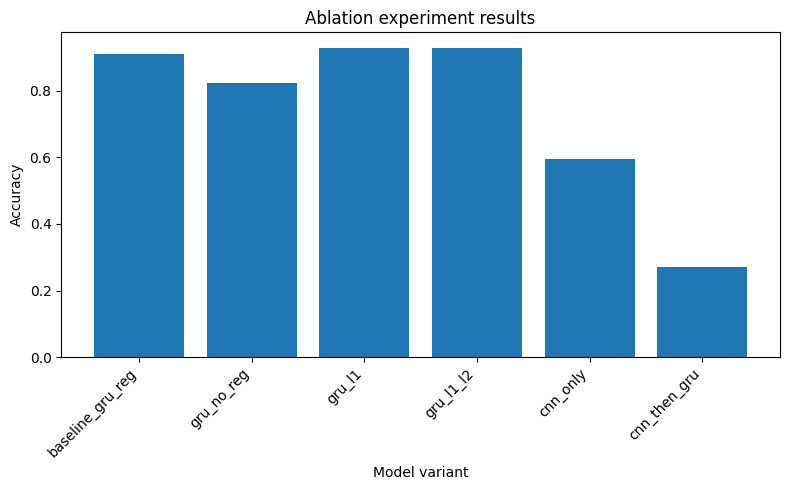

In [18]:
import os, random
import numpy as np
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
    Input, Conv1D, GRU, Dense, Dropout, Flatten,
    BatchNormalization, MaxPooling1D, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

# Reproducibility (best effort)
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Check that X_train etc exist
try:
    print("X_train shape:", X_train.shape)
    print("X_test shape :", X_test.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape :", y_test.shape)
except NameError:
    raise RuntimeError("X_train / X_test / y_train / y_test not found. Run the preprocessing cells first.")

timesteps = X_train.shape[1]
features = X_train.shape[2]
num_classes = y_train.shape[1]
input_shape = (timesteps, features)
print("Input shape:", input_shape, "Num classes:", num_classes)

# Common compile helper
def compile_model(model, lr=5e-4):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Model variants
# GRU-REG
def build_baseline_gru_reg():
    inp = Input(shape=input_shape)
    x = GRU(256, return_sequences=True, kernel_regularizer=regularizers.l2(0.002))(inp)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inp, out)
# GRU-No-REG
def build_gru_no_reg():
    inp = Input(shape=input_shape)
    x = GRU(256, return_sequences=True)(inp)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inp, out)
# GRU_L1
def build_gru_l1():
    inp = Input(shape=input_shape)
    x = GRU(256, return_sequences=True, kernel_regularizer=regularizers.l1(0.001))(inp)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inp, out)
# GRU-L1_L2
def build_gru_l1_l2():
    inp = Input(shape=input_shape)
    x = GRU(256, return_sequences=True, kernel_regularizer=regularizers.l1_l2(l1=0.0005, l2=0.0005))(inp)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inp, out)
# CNN-Only
def build_cnn_only():
    inp = Input(shape=input_shape)
    x = Conv1D(64, 3, padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.002))(inp)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Conv1D(128, 3, padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.002))(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.3)(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inp, out)
# CNN_Then_GRU
def build_cnn_then_gru():
    inp = Input(shape=input_shape)
    x = Conv1D(32, 3, padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.002))(inp)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(64, 3, padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.002))(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.3)(x)
    x = GRU(128, return_sequences=True)(x)
    x = GRU(64)(x)
    x = Dense(64, activation='elu')(x)
    x = Dropout(0.3)(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inp, out)

# Run single experiment: train, evaluate, print classification report
def run_experiment(name, build_fn, epochs=50, batch_size=32):
    print("\n=== Running:", name, "===\n")
    tf.keras.backend.clear_session()
    model = build_fn()
    compile_model(model)
    model.summary()
    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)
    ]
    hist = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs, batch_size=batch_size,
        callbacks=callbacks, verbose=2
    )
    # Predictions and metrics
    preds = model.predict(X_test)
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(y_test, axis=1)
    acc = accuracy_score(y_true, y_pred)
    print(f"\n{name} test accuracy: {acc:.4f}\n")
    print("Classification report:\n")
    print(classification_report(y_true, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    # return a small result dict
    return {'name': name, 'acc': float(acc)}

experiments = [
    ("baseline_gru_reg", build_baseline_gru_reg),
    ("gru_no_reg", build_gru_no_reg),
    ("gru_l1", build_gru_l1),
    ("gru_l1_l2", build_gru_l1_l2),
    ("cnn_only", build_cnn_only),
    ("cnn_then_gru", build_cnn_then_gru)
]

results = []
for name, fn in experiments:
    res = run_experiment(name, fn, epochs=50, batch_size=32)
    results.append(res)
    # save intermediate
    pd.DataFrame(results).to_csv('ablation_results_partial.csv', index=False)

results_df = pd.DataFrame(results)
results_df.to_csv('ablation_results.csv', index=False)
print("\nAll results:")
print(results_df)

plt.figure(figsize=(8,5))
plt.bar(results_df['name'], results_df['acc'])
plt.ylabel('Accuracy')
plt.xlabel('Model variant')
plt.title('Ablation experiment results')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**GRU → CNN model**

flip the order.
Instead of using CNN first, let GRU learn the time pattern, then CNN extract spatial/feature details.

In [19]:
def build_gru_then_cnn():
    inp = Input(shape=input_shape)
    x = GRU(128, return_sequences=True)(inp)
    x = GRU(64, return_sequences=True)(x)
    x = Conv1D(64, 3, activation='elu', padding='same')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.3)(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inp, out)

In [20]:
experiments = [
    ("gru_then_cnn", build_gru_then_cnn)
]

results = []
for name, fn in experiments:
    res = run_experiment(name, fn, epochs=30, batch_size=32)
    results.append(res)

pd.DataFrame(results)



=== Running: gru_then_cnn ===



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 44)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 50, 128)        │        66,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 50, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,676 (455.77 KB)

 Trainable params: 116,676 (455.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
253/253 - 5s - 20ms/step - accuracy: 0.2670 - loss: 1.3924 - val_accuracy: 0.2872 - val_loss: 1.3717 - learning_rate: 5.0000e-04
Epoch 2/30
253/253 - 2s - 10ms/step - accuracy: 0.3149 - loss: 1.3676 - val_accuracy: 0.3000 - val_loss: 1.3687 - learning_rate: 5.0000e-04
Epoch 3/30
253/253 - 2s - 10ms/step - accuracy: 0.3539 - loss: 1.3424 - val_accuracy: 0.3282 - val_loss: 1.3430 - learning_rate: 5.0000e-04
Epoch 4/30
253/253 - 3s - 13ms/step - accuracy: 0.3811 - loss: 1.3119 - val_accuracy: 0.3633 - val_loss: 1.3247 - learning_rate: 5.0000e-04
Epoch 5/30
253/253 - 2s - 10ms/step - accuracy: 0.4224 - loss: 1.2611 - val_accuracy: 0.3974 - val_loss: 1.2951 - learning_rate: 5.0000e-04
Epoch 6/30
253/253 - 2s - 10ms/step - accuracy: 0.4685 - loss: 1.1995 - val_accuracy: 0.4305 - val_loss: 1.2524 - learning_rate: 5.0000e-04
Epoch 7/30
253/253 - 2s - 10ms/step - accuracy: 0.5227 - loss: 1.1085 - val_accuracy: 0.4998 - val_loss: 1.1568 - learning_rate: 5.0000e-04
Epoch 8/30
253/253 -

,name,acc
0,gru_then_cnn,0.745428


**GRU → CNN model**

flip the order.
Instead of using CNN first, let GRU learn the time pattern, then CNN extract spatial/feature details.

In [21]:
def build_cnn_then_gru():
    inp = Input(shape=input_shape)

    # CNN block first — extracts spatial features
    x = Conv1D(64, 3, activation='elu', padding='same')(inp)
    x = Conv1D(128, 3, activation='elu', padding='same')(x)
    x = Dropout(0.3)(x)

    # GRU — learns temporal patterns from CNN features
    x = GRU(128, return_sequences=False,
            kernel_regularizer=regularizers.l2(0.001))(x)

    # Dense output layer
    out = Dense(num_classes, activation='softmax')(x)

    return Model(inp, out)

In [22]:
experiments = [
    ("cnn_then_gru", build_cnn_then_gru)
]

results = []
for name, fn in experiments:
    res = run_experiment(name, fn, epochs=30, batch_size=32)
    results.append(res)

pd.DataFrame(results)


=== Running: cnn_then_gru ===



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 44)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 50, 64)         │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,804 (518.77 KB)

 Trainable params: 132,804 (518.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
253/253 - 5s - 19ms/step - accuracy: 0.2569 - loss: 1.5262 - val_accuracy: 0.2600 - val_loss: 1.4851 - learning_rate: 5.0000e-04
Epoch 2/30
253/253 - 2s - 8ms/step - accuracy: 0.2721 - loss: 1.4540 - val_accuracy: 0.2556 - val_loss: 1.4505 - learning_rate: 5.0000e-04
Epoch 3/30
253/253 - 2s - 8ms/step - accuracy: 0.2763 - loss: 1.4318 - val_accuracy: 0.2635 - val_loss: 1.4370 - learning_rate: 5.0000e-04
Epoch 4/30
253/253 - 2s - 8ms/step - accuracy: 0.2751 - loss: 1.4214 - val_accuracy: 0.2610 - val_loss: 1.4294 - learning_rate: 5.0000e-04
Epoch 5/30
253/253 - 2s - 9ms/step - accuracy: 0.2874 - loss: 1.4118 - val_accuracy: 0.2664 - val_loss: 1.4221 - learning_rate: 5.0000e-04
Epoch 6/30
253/253 - 3s - 10ms/step - accuracy: 0.2941 - loss: 1.4032 - val_accuracy: 0.2664 - val_loss: 1.4174 - learning_rate: 5.0000e-04
Epoch 7/30
253/253 - 2s - 8ms/step - accuracy: 0.2974 - loss: 1.3971 - val_accuracy: 0.2734 - val_loss: 1.4152 - learning_rate: 5.0000e-04
Epoch 8/30
253/253 - 2s -

,name,acc
0,cnn_then_gru,0.365299
